<a href="https://colab.research.google.com/github/molaruna/percept_processing/blob/main/processJSON_percept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive to colab

In [71]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


Initialize environment

In [225]:
import io
import os
import datetime
import pandas as pd
import numpy as np
from pathlib import Path
import json
import csv
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
BASE_PATH = '/content/gdrive/My Drive/'

In [ ]:
dir_study = '<study_dir>'
#dir_json = '<json_file>'
fp = os.path.join(BASE_PATH, dir_ge + dir_json)

#functions

In [235]:
def str2int(s):
  l=list(str(s).split(','))
  arr=[]
  for val in l:
      try:
          arr.append(int(val))
      except ValueError:
          pass
  return np.asarray(arr)

def get_ms_arr(time_packets, packet_sizes, sr):
  step_size = 1000/sr #in ms
  
  ntimes = int(sum(packet_sizes))
  arr = np.empty(ntimes)

  stop_i = 0
  for i in range(len(packet_sizes)):   
    start_i = stop_i
    stop_i = start_i + packet_sizes[i]

    endpoint = time_packets[i] + step_size*packet_sizes[i] - 0.1
    interval = np.arange(time_packets[i], endpoint, step_size).astype(int)
    arr[start_i:stop_i] = interval
  
  return arr

def get_dt_arr(arr_ms, dt_init, dt_offset_init):
  dt_offset = datetime.datetime.strptime(dt_offset_init, '-%H:%M')
  dt_utc = datetime.datetime.strptime(dt_init, '%Y-%m-%dT%H:%M:%S.%fZ')
  dt = dt_utc - datetime.timedelta(hours=dt_offset.hour)
  arr_dt = [dt + datetime.timedelta(milliseconds=i) for i in arr_ms]
  return arr_dt

def get_ts_sense(data):
  nsides = len(data['BrainSenseTimeDomain'])
  for i in range(nsides):
    #get laterality of sensor
    ch_init = data['BrainSenseTimeDomain'][i]['Channel']
    implant_side = get_side(ch_init)

  #get array with timestamps in sequences of milliseconds
    time_packets = str2int(data['BrainSenseTimeDomain'][i]['TicksInMses'])
    packet_sizes = str2int(data['BrainSenseTimeDomain'][i]['GlobalPacketSizes'])
    sr = data['BrainSenseTimeDomain'][i]['SampleRateInHz']
    arr_ms = get_ms_arr(time_packets, packet_sizes, sr)
    
    #convert timestamp array into datetime
    dt_init = data['BrainSenseTimeDomain'][i]['FirstPacketDateTime']
    dt_offset_init = data['ProgrammerUtcOffset']
    arr_dt = get_dt_arr(arr_ms, dt_init, dt_offset_init)

    #get voltage timeseries data
    voltage = data['BrainSenseTimeDomain'][i]['TimeDomainData']
    column_name = 'voltage' + '_' + implant_side
    if i == 0:
      df = pd.DataFrame(data = voltage,
                        columns = [column_name],
                        index = arr_dt)
    if i > 0:
      df[column_name] = voltage

  return df

def get_id(fp):
  return os.path.basename(os.path.dirname(os.path.dirname(fp)))

def get_side(ch_init):
  return str.split(ch_init, sep = '_')[-1].lower()

def get_ch(ch_init):
  num_dict = {
    'ZERO': '0',
    'ONE': '1',
    'TWO': '2',
    'THREE': '3',
    'FOUR': '4',
    'FIVE': '5',
    'SIX': '6',
    'SEVEN': '7',
    'EIGHT': '8',
    'NINE': '9',
    'TEN': '10',
    'ELEVEN': '11',
    'TWELVE': '12'
  }

  ch_str = str.split(ch_init, sep = '_')[:-1]
  ch_int = '-'.join(num_dict[i] for i in reversed(ch_str))
  return '+' + ch_int

def get_stim_contact(ch_sense_contacts):
  stim_contact_dict = {
      '+2-0': '1',
      '+3-1': '2'
  }

  stim_contact = stim_contact_dict[ch_sense_contacts]
  return stim_contact

def get_settings(data, fp):
  subj_id = get_id(fp)
  df = pd.DataFrame(data = [subj_id], columns = ['subj_id'])

  nsides = len(data['BrainSenseTimeDomain'])
  for i in range(nsides):
    ch_init = data['BrainSenseTimeDomain'][i]['Channel']
    implant_side = get_side(ch_init)
    df[implant_side + '_sr'] = data['BrainSenseTimeDomain'][i]['SampleRateInHz']

    ch_sense_contacts = get_ch(ch_init)
    df[implant_side + '_ch'] = ch_sense_contacts
    df[implant_side + '_stim_contact'] = get_stim_contact(ch_sense_contacts)
  
  return df

def get_ms_arr_stim(stim_data):
  ntimes = len(stim_data)
  arr_ms = [stim_data[i]['TicksInMs'] for i in range(ntimes)]

  return arr_ms

def get_ma_df(stim_data, arr_dt):
  ntimes = len(arr_dt)

  ma_left = [stim_data[i]['Left']['mA'] for i in range(ntimes)]
  ma_right = [stim_data[i]['Right']['mA'] for i in range(ntimes)]

  data = np.column_stack((ma_left, ma_right))

  df = pd.DataFrame(data = data, 
                    columns = ['stim_amp_left', 'stim_amp_right'], 
                    index = arr_dt)

  return df

def get_ts_stim(data):
  stim_data = data['BrainSenseLfp'][0]['LfpData']
  sr = data['BrainSenseLfp'][0]['SampleRateInHz']
  arr_ms = get_ms_arr_stim(stim_data)

  #convert timestamp array into datetime
  dt_init = data['BrainSenseLfp'][0]['FirstPacketDateTime']
  dt_offset_init = data['ProgrammerUtcOffset']
  arr_dt = get_dt_arr(arr_ms, dt_init, dt_offset_init)

  #get stimulation amplitude data
  df_stim = get_ma_df(stim_data, arr_dt)

  return df_stim

def get_data(jsonfile, ts_sense=True, ts_stim=True, settings=True):
  df_ts_sense = []
  df_ts_stim = []
  df_settings = []

  with open(jsonfile)as f:
    data = json.load(f)

  if ts_sense == True:
    df_ts_sense = get_ts_sense(data)

  if ts_stim == True:
    df_ts_stim = get_ts_stim(data)

  if settings == True:
    df_settings = get_settings(data, jsonfile)

  return [df_ts_sense, df_ts_stim, df_settings]

def get_sr_arr(df_settings):
  if 'left_sr' in df_settings:
    fs = np.array([df_settings.left_sr])
    if 'right_sr' in df_settings:
      fs = np.append(fs, [[df_settings.right_sr]])
      try:
        df_settings.right_sr != df_settings.left_sr
      except ValueError:
        print('sampling rates differ across hemispheres')
  else:
    fs = np.array([df_settings.right_sr])
  return fs

def time2freq(df_ts_sense, df_settings):
  nchannel = df_ts_sense.shape[1]
  fs_arr = get_sr_arr(df_settings)

  for i in range(nchannel):
    [f, Pxx] = signal.welch(df_ts_sense.iloc[:, i], fs = fs_arr[i])
    Pxx_log = np.log10(Pxx)
    colname = df_ts_sense.columns[i].replace('voltage', 'psd')
    if i == 0:
      df_psd = pd.DataFrame(data = Pxx_log, columns = [colname], 
                            index = np.round(f).astype(int))
    else:
      df_psd[colname] = Pxx_log
  return df_psd

def plot_ts_sense(df_ts_sense, df_settings):
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
  if 'voltage_left' in df_ts_sense:
    plt.plot(df_ts_sense.voltage_left, color = 'blue', alpha = 0.8, 
             label = 'left_ch' + df_settings.left_ch[0])
  if 'voltage_right' in df_ts_sense:
    plt.plot(df_ts_sense.voltage_right, color = 'orange', alpha = 0.8, 
            label = 'right_ch' + df_settings.right_ch[0])

  plt.xlabel('time (HH:MM:SS)')
  plt.xticks(rotation = 45)
  plt.ylabel('voltage (uV)')
  plt.title('Voltage timeseries: ' + str(df_settings.subj_id[0]))
  plt.legend()

def plot_ts_stim(df_ts_stim, df_settings):
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
  plt.plot(df_ts_stim.stim_amp_left, color = 'blue', 
           label = 'left_c' + df_settings.left_stim_contact[0])
  plt.plot(df_ts_stim.stim_amp_right, color = 'orange', 
           label = 'right_c' + df_settings.right_stim_contact[0])
  
  plt.xlabel('time (HH:MM:SS)')
  plt.xticks(rotation = 45)
  plt.ylabel('amplitude (mA)')
  plt.legend()
  plt.title('Stimulation amplitudes: ' + str(df_settings.subj_id[0]))

def plot_psd(df_psd, df_settings):
  if 'psd_left' in df_psd:
    plt.plot(df_psd.psd_left, color = 'blue', 
             label = 'left_ch' + df_settings.left_ch[0])
  if 'psd_right' in df_psd:
    plt.plot(df_psd.psd_right, color = 'orange',
             label = 'right_ch' + df_settings.right_ch[0])
  
  plt.xlabel('frequency (Hz)')
  plt.ylabel('log(power)')
  plt.legend()
  plt.title('Power spectra: ' + str(df_settings.subj_id[0]))
  pass


#Process data

In [223]:
[df_ts_sense, df_ts_stim, df_settings] = get_data(fp)

In [232]:
df_ts_sense

,voltage_left,voltage_right
2022-02-18 08:45:08.400,2.004050,-11.801625
2022-02-18 08:45:08.404,0.445344,-12.692314
2022-02-18 08:45:08.408,1.892713,-10.354256
2022-02-18 08:45:08.412,1.892713,-8.906887
2022-02-18 08:45:08.416,0.222672,-7.125509
...,...,...
2022-02-18 08:51:27.878,-1.670041,7.236846
2022-02-18 08:51:27.882,0.779353,10.910936
2022-02-18 08:51:27.886,-1.336033,7.682190
2022-02-18 08:51:27.890,-3.451419,2.672066


In [ ]:
df_ts_stim

In [183]:
df_settings

,subj_id,left_sr,left_ch,left_stim_contact,right_sr,right_ch,right_stim_contact
0,P01_pilot,250,+2-0,1,250,+3-1,2


In [204]:
df_psd = time2freq(df_ts_sense, df_settings)
print(df_psd)

     psd_left  psd_right
0    0.081579  -0.400187
1    0.822866   0.380678
2    0.946190   0.517829
3    0.824026   0.500864
4    0.771108   0.390327
..        ...        ...
121 -3.520239  -3.572121
122 -3.467525  -3.590099
123 -3.370259  -3.615298
124 -3.588281  -3.673108
125 -3.968149  -3.972706

[129 rows x 2 columns]


#Plot results

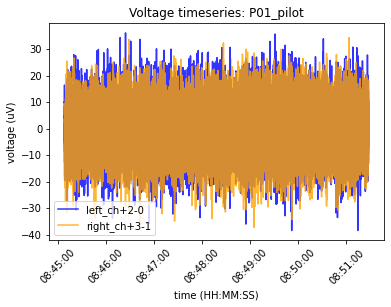

In [236]:
plot_ts_sense(df_ts_sense, df_settings)

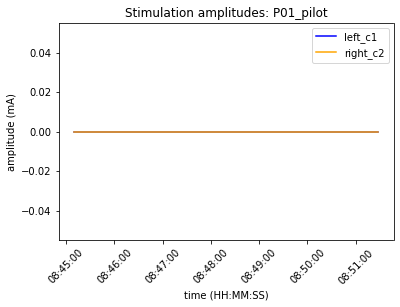

In [229]:
plot_ts_stim(df_ts_stim, df_settings)

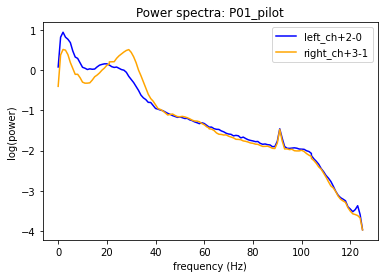

In [205]:
plot_psd(df_psd, df_settings)